<a href="https://colab.research.google.com/github/deriiinjv/pytorch-ml-experiments/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms

import matplotlib.pyplot as plt
import numpy as np
import random
import time
%matplotlib inline

In [5]:
def set_seeds():
  seed_val=43
  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_val)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])
train_set=datasets.FashionMNIST(root="F_MNIST_data",download=True,train=True,transform=transform)
val_set=datasets.FashionMNIST(root="F_MNIST_data",download=True,train=False,transform=transform)
print("Total Train Img",len(train_set))
print("Total Val Img",len(val_set))

100%|██████████| 4.42M/4.42M [00:01<00:00, 3.75MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]

Total Train Img 60000
Total Val Img 10000


In [7]:
train_loader=torch.utils.data.DataLoader(train_set,shuffle=True,batch_size=64)
val_loader=torch.utils.data.DataLoader(val_set,shuffle=False,batch_size=64)

In [8]:
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"  }

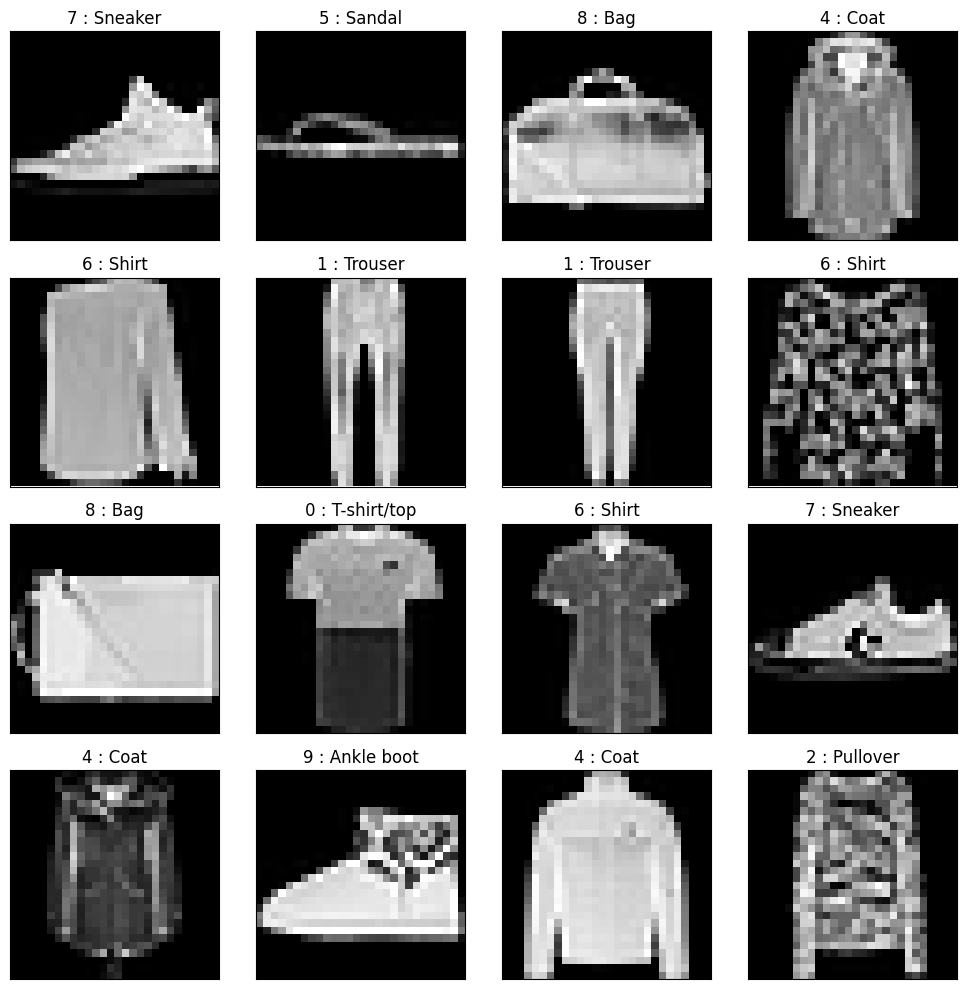

In [9]:
def visualize(train_loader, num_images=16):
    fig = plt.figure(figsize=(10, 10))

    images, labels = next(iter(train_loader))

    num_rows = 4
    num_cols = int(np.ceil(num_images / num_rows))

    for idx in range(min(num_images, len(images))):
        ax = fig.add_subplot(num_rows, num_cols, idx + 1)

        image = images[idx]
        label = labels[idx]

        ax.imshow(np.squeeze(image), cmap='gray')
        ax.set_title(f"{label.item()} : {class_mapping[label.item()]}")
        ax.set_xticks([])
        ax.set_yticks([])

    fig.tight_layout()
    plt.show()
visualize(train_loader)

In [10]:
class MLP(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.fc0=nn.Linear(784,512)
    self.bn0=nn.BatchNorm1d(512)
    self.fc1=nn.Linear(512,256)
    self.bn1=nn.BatchNorm1d(256)
    self.fc2=nn.Linear(256,128)
    self.bn2=nn.BatchNorm1d(128)
    self.fc3=nn.Linear(128,64)
    self.bn3=nn.BatchNorm1d(64)
    self.fc4=nn.Linear(64,num_classes)
    self.dropout=nn.Dropout(p=0.3)
  def forward(self,x):
    x=x.view(x.shape[0],-1)
    x=F.relu(self.bn0(self.fc0(x)))
    x=self.dropout(x)
    x=F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x=F.relu(self.bn3(self.fc3(x)))
    x=F.log_softmax(self.fc4(x),dim=1)
    return x
mlp_model=MLP(num_classes=10)

In [11]:
!pip install torchinfo
from torchinfo import summary

In [12]:
print(summary(mlp_model, input_size = (1,1,28,28), row_settings = ["var_names"]))

Layer (type (var_name))                  Output Shape              Param #
MLP (MLP)                                [1, 10]                   --
├─Linear (fc0)                           [1, 512]                  401,920
├─BatchNorm1d (bn0)                      [1, 512]                  1,024
├─Dropout (dropout)                      [1, 512]                  --
├─Linear (fc1)                           [1, 256]                  131,328
├─BatchNorm1d (bn1)                      [1, 256]                  512
├─Linear (fc2)                           [1, 128]                  32,896
├─BatchNorm1d (bn2)                      [1, 128]                  256
├─Linear (fc3)                           [1, 64]                   8,256
├─BatchNorm1d (bn3)                      [1, 64]                   128
├─Linear (fc4)                           [1, 10]                   650
Total params: 576,970
Trainable params: 576,970
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.58
Input size (MB): 0.

In [13]:
criterion = F.nll_loss
optimizer = optim.Adam(mlp_model.parameters(), lr = 1e-2)
num_epochs = 10
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [14]:
def train(model, trainloader, criterion, optimizer,DEVICE):
    model.train()
    model.to(DEVICE)
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    for images, labels in trainloader:
        images,labels = images.to(DEVICE),labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(trainloader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [15]:
def validation(model, val_loader, criterion,DEVICE):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images,labels = images.to(DEVICE),labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) #(B, class_id)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions / total_samples
    return avg_loss, accuracy

In [16]:
def main(model, trainloader, val_loader, epochs=5, DEVICE = "cuda"):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, trainloader, criterion, optimizer, DEVICE)
        val_loss, val_accuracy = validation(model, val_loader, criterion, DEVICE)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 01/10 - Train Loss: 0.5448, Train Accuracy: 80.29% - Val Loss: 0.4313, Val Accuracy: 84.18%
Epoch 02/10 - Train Loss: 0.4179, Train Accuracy: 84.94% - Val Loss: 0.3952, Val Accuracy: 85.52%
Epoch 03/10 - Train Loss: 0.3818, Train Accuracy: 86.20% - Val Loss: 0.3710, Val Accuracy: 86.63%
Epoch 04/10 - Train Loss: 0.3569, Train Accuracy: 86.93% - Val Loss: 0.3398, Val Accuracy: 87.27%
Epoch 05/10 - Train Loss: 0.3373, Train Accuracy: 87.59% - Val Loss: 0.3497, Val Accuracy: 87.01%
Epoch 06/10 - Train Loss: 0.3252, Train Accuracy: 88.02% - Val Loss: 0.3425, Val Accuracy: 87.46%
Epoch 07/10 - Train Loss: 0.3090, Train Accuracy: 88.49% - Val Loss: 0.3436, Val Accuracy: 87.14%
Epoch 08/10 - Train Loss: 0.3013, Train Accuracy: 88.91% - Val Loss: 0.3274, Val Accuracy: 88.22%
Epoch 09/10 - Train Loss: 0.2888, Train Accuracy: 89.25% - Val Loss: 0.3174, Val Accuracy: 88.60%
Epoch 10/10 - Train Loss: 0.2788, Train Accuracy: 89.60% - Val Loss: 0.3161, Val Accuracy: 88.69%


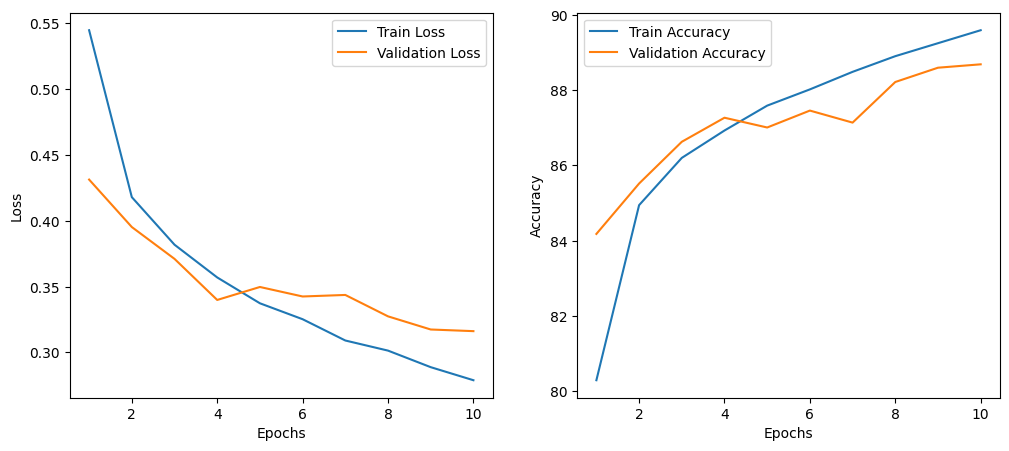

In [17]:
main(mlp_model, train_loader, val_loader, epochs = num_epochs, DEVICE = DEVICE)

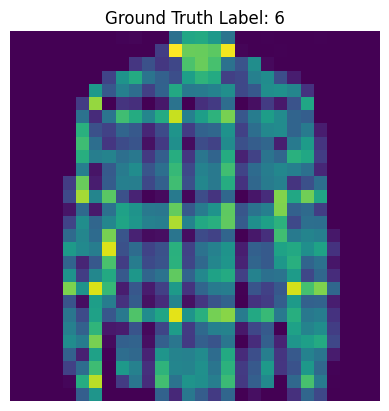

In [18]:
images, gt_labels = next(iter(val_loader))

rand_idx = random.choice(range(len(images)))

plt.imshow(images[rand_idx].squeeze())
plt.title("Ground Truth Label: " + str(int(gt_labels[rand_idx])), fontsize = 12)
plt.axis("off")
plt.show()

In [20]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn

def pred_batch(model,batch_inputs):
  model.eval()
  batch_outputs=model(batch_inputs)
  with torch.no_grad():
    batch_probs=batch_outputs.softmax(dim=1)
  batch_cls_ids=batch_probs.argmax(dim=1)
  return batch_cls_ids.cpu()

In [21]:
val_target_labels = []
val_predicted_labels = []

for image_batch, target_batch in val_loader:
    image_batch = image_batch.to(DEVICE)

    batch_pred_cls_id = pred_batch(mlp_model, image_batch)

    val_predicted_labels.append(batch_pred_cls_id)
    val_target_labels.append(target_batch)

val_target_labels = torch.cat(val_target_labels).numpy()
val_predicted_labels = torch.cat(val_predicted_labels).numpy()

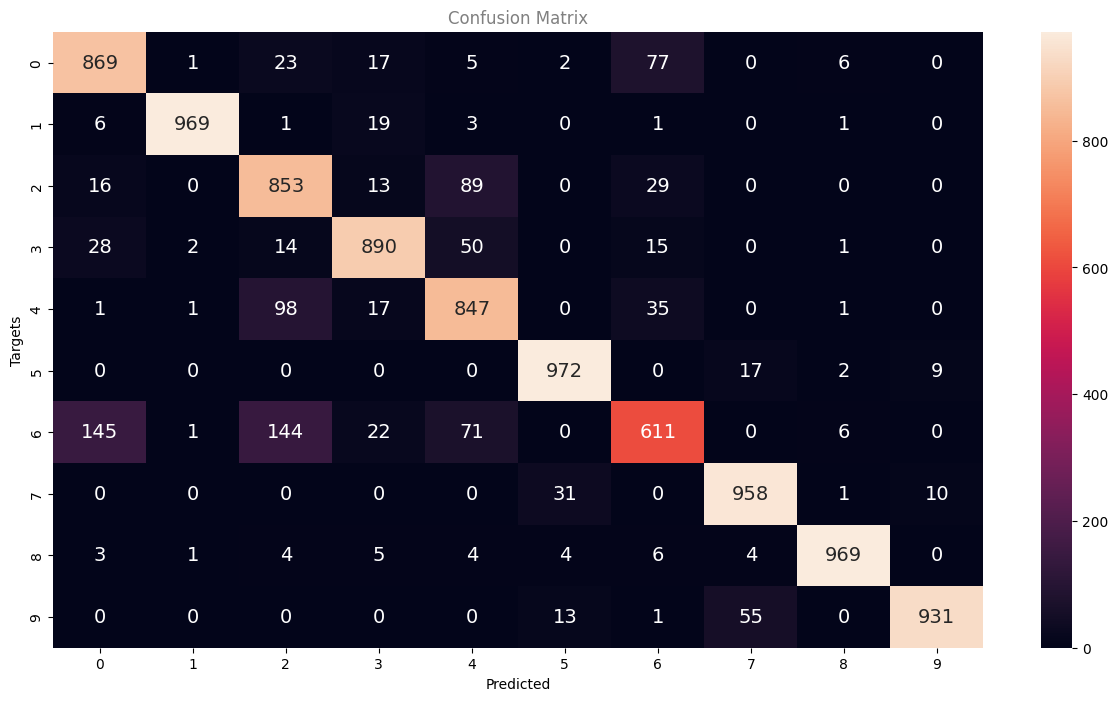

In [22]:
cm = confusion_matrix(y_true=val_target_labels, y_pred = val_predicted_labels)

plt.figure(figsize= [15,8])
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Targets")
plt.title(f"Confusion Matrix", color="gray")
plt.show()